## Генератор траекторий Геометрического Винеровского процесса

Геометрический Винеровский процесс (далее GBM) - случ. процесс, в котором логарифм случайной величины (сечения) ведёт себя как обычное Броуновское движение (т.е. является Винеровским процессом)


Вывод решения опирается на Лемму Ито, полный вывод можно [найти здесь](https://www.quantstart.com/articles/Geometric-Brownian-Motion/). Он согласется с [формулой из Википедии](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)

Для генерации Винеровского процесса (Броуновского движения) воспользуемся теоремой о том, что оно приближается случайными блужданиями:
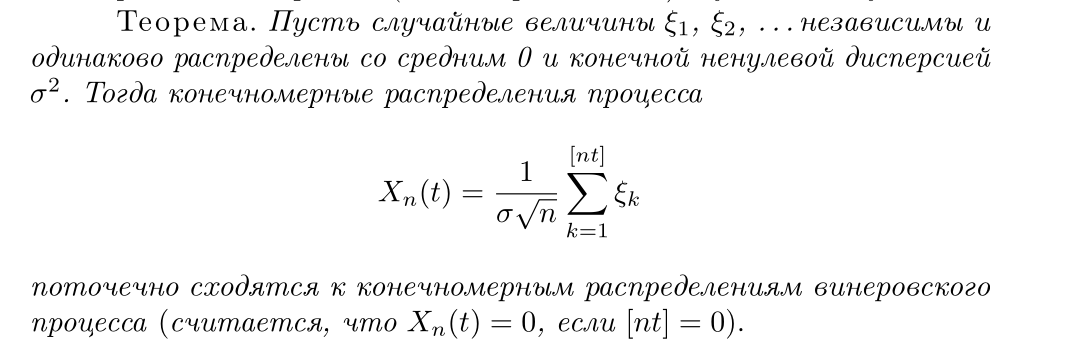

~~Upd. Формула с целой частью оказалась неинтерпретируемой и там из более простых соображений следует (свойства Винеровского процесса: что он Марковский и как распределены приращения) следует такой же результат. Так что теорема неактуальна, будет просто как общий теор. результат~~

~~Случайные величины $\xi_i$ будем брать из $\mathcal{N}{(0, 1)}$, потому что эмпирически шум в большинстве случаев нормален.~~ Дисперсию из теоремы со скрина можно самостоятельно задать параметром `random_walk_scale`

В классе броуновского движения сначала реализуем Винеровский процесс, потом воспользуемся им для реализации GBM.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm

In [3]:
class BrownianMotion:

    def __init__(self, drift=1, var=1, scale=1, iters=1000):
        self.drift_rate = drift  # кф-т дрейфа (кф-т сноса стох. процесса)
        self.variance_rate = var  # кф-т диффузии (дисперсия)
        self.random_walk_scale = scale  # стандартное отклонение для случ. блужданий
        self.n_iter = iters  # количество случ. величин для генерации Броуновского движения

    def random_walk(self, t):
        dt = t / (self.n_iter - 1)
        W = np.zeros(self.n_iter)
        for iter in range(1, self.n_iter):
            ksi_i = sps.norm.rvs(loc=0, scale=self.random_walk_scale)
            W[iter] = W[iter - 1] + ksi_i * np.sqrt(dt)

        return W

    def geometric_brownian_motion(self, S_0, t):
        '''
        Ф-я возвращает аналит. формулу для геом. винеровского процесса
        '''
        time = np.linspace(0, t, self.n_iter)
        return S_0 * np.exp((self.drift_rate - self.variance_rate ** 2 * 0.5) * time + self.variance_rate * self.random_walk(t))

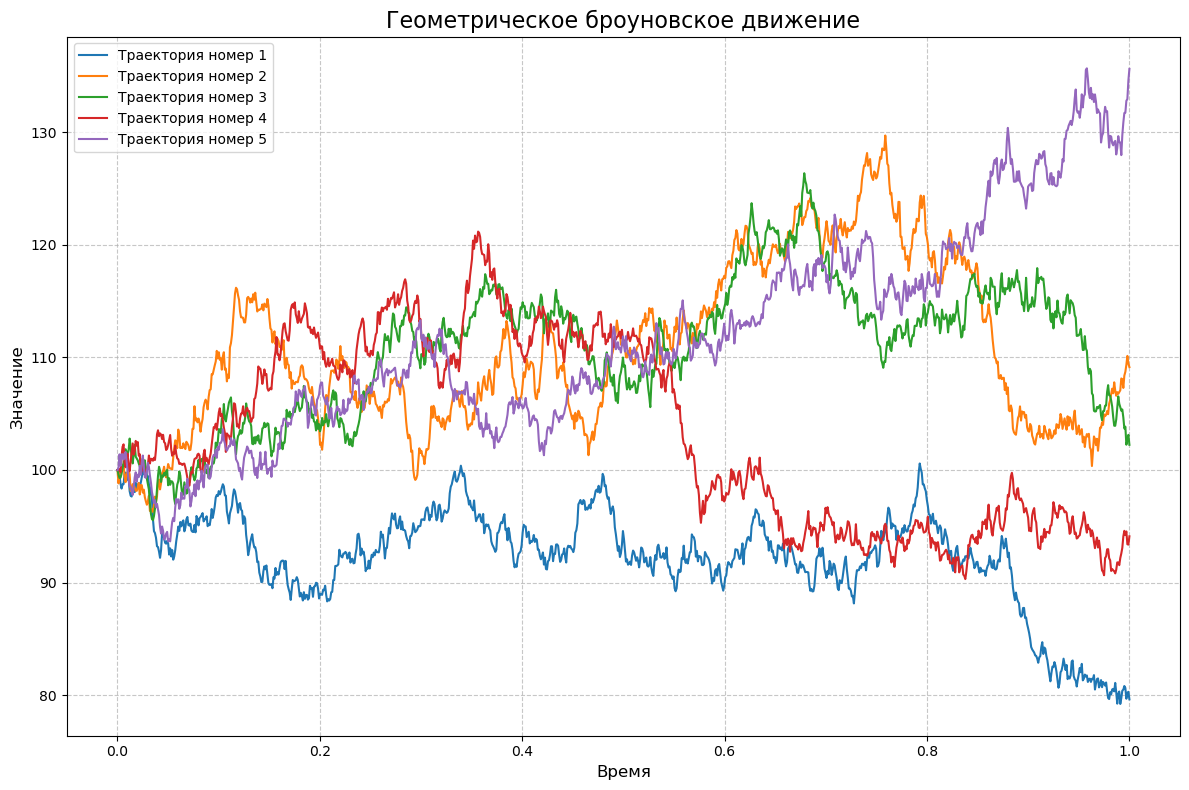

In [4]:
bm = BrownianMotion(drift = 0.1, var = 0.2, scale = 1, iters = 1000)

S_0 = 100
T = 1
num_paths = 5  # кол-во траекторий

t = np.linspace(0, T, bm.n_iter)

trajectories = np.array([bm.geometric_brownian_motion(S_0, T) for _ in range(num_paths)])

plt.figure(figsize = (12, 8))

for i in range(num_paths):
    plt.plot(t, trajectories[i], label=f'Траектория номер {i+1}')

plt.title('Геометрическое броуновское движение', fontsize = 16)
plt.xlabel('Время', fontsize = 12)
plt.ylabel('Значение', fontsize = 12)
plt.legend(fontsize = 10)
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.tight_layout()

plt.show()

### Европейских опционы с помощью Монте-Карло, сравнение с Блеком-Шоулзом

Под Монте-Карло тут подразумевается тот самый М-К для приближённого интегрирования, который круче чем метод прямоугольников. Сходимость М-К составляет $O(\frac{1}{\sqrt{N}})$, где $N$ - это количество точек. Алгоритм:

1. Написанным генератором генерим много траекторий. Функция `geometric_brownian_motion` из прошлой ячейки вторым аргументом принимает момент времени `T`, то есть можем найти стоимость актива в этот момент времени. При необходимости ещё дисконтируем эту стоимость на какой-то процент (рисковая ставка или безрисковая).
2. Усредням результаты, среднее и будет ответом (вспомним, что ровно то же самое мы делаем и в методе М-К)
3. Полученное число надо ещё сравнить с числом, полученным из формулы Блека-Шоулза

In [11]:
def price_european_option_mc(S_0, K, r, T, bm_instance, n_simulations = 1000, option_type = 'call'):
    """
    Метод Монте-Карло
    K - цена исполнения опциона
    r - процентная ставка (мб безрисковая, мб нет)
    option_type - тип опциона. Если 'call', то право купить, если 'put', то право продать
    """
    
    bm_instance.drift_rate = r
    payoffs = list()
    
    for _ in range(n_simulations):
        trajectory = bm_instance.geometric_brownian_motion(S_0, T)
        S_T = trajectory[-1]
        
        if option_type == 'call':
            payoff = max(S_T - K, 0)
        else:
            payoff = max(K - S_T, 0)
        
        payoffs.append(payoff)
        
    option_price = np.mean(payoffs) * np.exp(-r * T) # подразумеваем непрерывное начисление процентов
    
    return option_price

In [8]:
def black_scholes(S0, K, r, sigma, T, option_type = 'call'):
    """
    Просто формула Блека-Шоулза с Википедии
    """
    
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S0 * sps.norm.cdf(d1) - K * np.exp(-r * T) * sps.norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * sps.norm.cdf(-d2) - S0 * sps.norm.cdf(-d1)
        
    return price

100%|██████████| 25/25 [07:48<00:00, 18.72s/it]


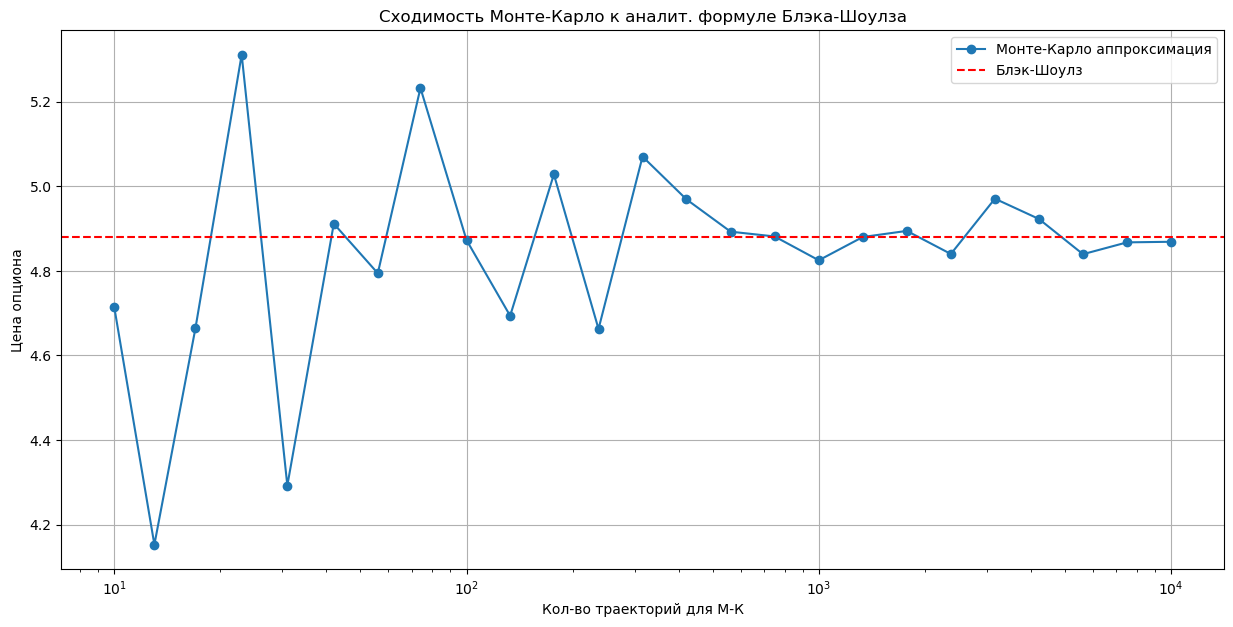

In [21]:
S0, K, r, sigma, T = 100, 100, 0.05, 0.02, 1

bm = BrownianMotion(drift = r, var = sigma, scale = 1, iters = 1000)
bs_price = black_scholes(S0, K, r, sigma, T, option_type = 'call')

n_simulations_list = np.logspace(1, 4, 25, dtype = int) # сетка от 10^1 до 10^4 
mc_prices = []

for n_sim in tqdm(n_simulations_list):
    mc_price = price_european_option_mc(S0, K, r, T, bm, n_simulations = n_sim, option_type = 'call')
    mc_prices.append(mc_price)

plt.figure(figsize = (15, 7))
plt.plot(n_simulations_list, mc_prices, label = "Монте-Карло аппроксимация", marker = 'o')
plt.axhline(y=bs_price, color = 'r', linestyle = '--', label = "Блэк-Шоулз")
plt.xscale("log")
plt.xlabel("Кол-во траекторий для М-К")
plt.ylabel("Цена опциона")
plt.title("Сходимость Монте-Карло к аналит. формуле Блэка-Шоулза")
plt.legend()
plt.grid()
plt.show()